In [50]:
import pandas as pd
import numpy as np
from tsfresh.feature_extraction import extract_features, EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight
from tsfresh.feature_selection import select_features
from tsfresh.feature_extraction import extract_features, MinimalFCParameters
from sklearn.feature_selection import SelectPercentile, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


In [2]:
raw_data_prep_dir = '../raw_data/pads-parkinsons-disease-smartwatch-dataset-1.0.0/preprocessed/'

#/Users/yulingsun/code/marzecovaa/spark/raw_data/pads-parkinsons-disease-smartwatch-dataset-1.0.0

In [3]:
file_list = pd.read_csv(raw_data_prep_dir  + "file_list.csv")
file_list

,resource_type,id,study_id,condition,disease_comment,age_at_diagnosis,age,height,weight,gender,handedness,appearance_in_kinship,appearance_in_first_grade_kinship,effect_of_alcohol_on_tremor,label
0,patient,1,PADS,Healthy,-,56,56,173,78,male,right,True,True,Unknown,0
1,patient,2,PADS,Other Movement Disorders,Left-Sided resting tremor and hypokinesia with...,69,81,193,104,male,right,False,NaN,No effect,2
2,patient,3,PADS,Healthy,-,45,45,170,78,female,right,False,NaN,Unknown,0
3,patient,4,PADS,Parkinson's,IPS akinetic-rigid type,63,67,161,90,female,right,False,NaN,No effect,1
4,patient,5,PADS,Parkinson's,IPS tremordominant type,65,75,172,86,male,left,False,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,patient,465,PADS,Parkinson's,IPS mixed type,62,65,175,80,male,right,True,False,No effect,1
465,patient,466,PADS,Healthy,-,84,84,172,74,female,right,True,True,No effect,0
466,patient,467,PADS,Parkinson's,"Essential Tremor, starting IPS tremordominant ...",55,57,190,100,male,right,False,NaN,Improvement,1
467,patient,468,PADS,Parkinson's,IPS mixed type,73,76,198,118,male,right,False,NaN,No effect,1


In [4]:
n_id = len(file_list['id'])
n_id

469

In [7]:
file_list[file_list['id']==5]['label']

4    1
Name: label, dtype: int64

In [8]:
time_data = []
y = []
X_to_split = []
for idx, subject_idx in enumerate(file_list['id']):
    file_name = raw_data_prep_dir + f'movement/{subject_idx:03d}_ml.bin'
    time_idx_data = np.fromfile(file_name, dtype=np.float32).reshape((-1, 976))
    time_data.append(time_idx_data)
    y_idx = file_list[file_list['id']==subject_idx].label.values
    X_id = idx
    y.append(y_idx)
    X_to_split.append(X_id)

X_to_split = np.array(X_to_split)
y = np.array(y).flatten()
print(X_to_split.shape, y.shape)


(469,) (469,)


In [69]:
channels = []
for task in ["Relaxed1", "Relaxed2", "RelaxedTask1", "RelaxedTask2", "StretchHold", "HoldWeight",
                "DrinkGlas", "CrossArms", "TouchNose", "Entrainment1", "Entrainment2"]:
    for device_location in ["LeftWrist", "RightWrist"]:
        for sensor in ["Acceleration", "Rotation"]:
            for axis in ["X", "Y", "Z"]:
                channel = f"{task}_{sensor}_{device_location}_{axis}"
                channels.append(channel)
len(channels)
print(channels)

['Relaxed1_Acceleration_LeftWrist_X', 'Relaxed1_Acceleration_LeftWrist_Y', 'Relaxed1_Acceleration_LeftWrist_Z', 'Relaxed1_Rotation_LeftWrist_X', 'Relaxed1_Rotation_LeftWrist_Y', 'Relaxed1_Rotation_LeftWrist_Z', 'Relaxed1_Acceleration_RightWrist_X', 'Relaxed1_Acceleration_RightWrist_Y', 'Relaxed1_Acceleration_RightWrist_Z', 'Relaxed1_Rotation_RightWrist_X', 'Relaxed1_Rotation_RightWrist_Y', 'Relaxed1_Rotation_RightWrist_Z', 'Relaxed2_Acceleration_LeftWrist_X', 'Relaxed2_Acceleration_LeftWrist_Y', 'Relaxed2_Acceleration_LeftWrist_Z', 'Relaxed2_Rotation_LeftWrist_X', 'Relaxed2_Rotation_LeftWrist_Y', 'Relaxed2_Rotation_LeftWrist_Z', 'Relaxed2_Acceleration_RightWrist_X', 'Relaxed2_Acceleration_RightWrist_Y', 'Relaxed2_Acceleration_RightWrist_Z', 'Relaxed2_Rotation_RightWrist_X', 'Relaxed2_Rotation_RightWrist_Y', 'Relaxed2_Rotation_RightWrist_Z', 'RelaxedTask1_Acceleration_LeftWrist_X', 'RelaxedTask1_Acceleration_LeftWrist_Y', 'RelaxedTask1_Acceleration_LeftWrist_Z', 'RelaxedTask1_Rotation_L

In [10]:
time_data_array = np.array(time_data)
print(time_data_array.shape)

(469, 132, 976)


In [119]:
time_data_array

array([[[-7.18307542e-03, -7.97853246e-03, -7.81304389e-03, ...,
          1.72191102e-03,  2.75583961e-03,  1.86453806e-03],
        [-2.89946591e-04, -1.60217297e-03, -2.94661568e-03, ...,
          2.54398095e-04,  1.34622052e-04,  1.96311320e-03],
        [ 4.12839325e-03,  3.16892145e-03,  2.27304758e-03, ...,
          4.87453333e-04,  1.48784160e-03, -4.89200873e-04],
        ...,
        [ 7.97079727e-02,  7.00292438e-02,  4.42504846e-02, ...,
         -1.05950013e-02, -6.27173204e-03,  3.40433232e-03],
        [-1.02272712e-01, -9.49295759e-02, -7.82209039e-02, ...,
          6.99309483e-02,  6.35627955e-02,  5.61850406e-02],
        [-1.67727657e-02, -1.67666413e-02, -2.31204107e-02, ...,
         -1.13539649e-02, -1.77311711e-02, -2.30463073e-02]],

       [[ 8.36125482e-03,  5.90733485e-03, -4.05572727e-03, ...,
         -1.88475254e-03, -9.19213693e-04,  9.88525455e-04],
        [-1.96502102e-03,  2.39871955e-03, -4.03387845e-03, ...,
         -1.77135039e-02, -1.80895422e

In [70]:
X_to_split

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [73]:
X_to_split.shape

(469,)

In [11]:
X_train_idx, X_test_idx, y_train, y_test = train_test_split(X_to_split, y, test_size=0.20, random_state=42, stratify = y)

In [12]:
X_train = time_data_array[X_train_idx]
X_test = time_data_array[X_test_idx]
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))
X = time_data_array
X.shape[0]

375 94
375 94


469

In [13]:
# shape (N, F, T)
N, F, T = X_test.shape
feature_names = [f"feat_{i}" for i in range(F)]

def make_long_df(batch_data: np.ndarray, id_offset: int = 0) -> pd.DataFrame:

    n_batch = batch_data.shape[0]


    x = np.transpose(batch_data, (0, 2, 1))
    values = x.reshape(-1)

    ids = np.repeat(np.arange(id_offset, id_offset + n_batch), T * F)


    times = np.tile(np.repeat(np.arange(T), F), n_batch)


    kinds_idx = np.tile(np.arange(F), n_batch * T)
    kinds = np.array(feature_names, dtype=object)[kinds_idx]

    return pd.DataFrame({"id": ids, "time": times, "kind": kinds, "value": values})

df_long = make_long_df(X, id_offset=0)


X_features = extract_features(
    df_long,
    column_id="id",
    column_sort="time",
    column_kind="kind",
    column_value="value",
    default_fc_parameters=MinimalFCParameters(),
    n_jobs=0
)

print(X_features.shape)  # (375, num_features)

Feature Extraction: 100%|██████████| 61908/61908 [01:02<00:00, 985.14it/s] 


(469, 1320)


In [120]:
df_long.shape

df_long

,id,time,kind,value
0,0,0,feat_0,-0.007183
1,0,0,feat_1,-0.000290
2,0,0,feat_2,0.004128
3,0,0,feat_3,-0.006711
4,0,0,feat_4,-0.008454
...,...,...,...,...
60422203,468,975,feat_127,0.020523
60422204,468,975,feat_128,-0.009127
60422205,468,975,feat_129,-0.117109
60422206,468,975,feat_130,-0.159601


In [15]:
X.shape

(469, 132, 976)

In [31]:
X_features.head(5)

,feat_0__sum_values,feat_0__median,feat_0__mean,feat_0__length,feat_0__standard_deviation,feat_0__variance,feat_0__root_mean_square,feat_0__maximum,feat_0__absolute_maximum,feat_0__minimum,...,feat_99__sum_values,feat_99__median,feat_99__mean,feat_99__length,feat_99__standard_deviation,feat_99__variance,feat_99__root_mean_square,feat_99__maximum,feat_99__absolute_maximum,feat_99__minimum
0,-0.237587,-0.000077,-0.000243,976.0,0.002691,0.000007,0.002702,0.009177,0.012745,-0.012745,...,-67.718842,0.099464,-0.069384,976.0,2.833473,8.028572,2.834323,6.799439,10.478931,-10.478931
1,0.301411,0.000378,0.000309,976.0,0.008624,0.000074,0.008629,0.029810,0.043526,-0.043526,...,-147.278595,-0.157933,-0.150900,976.0,2.830704,8.012886,2.834723,11.696977,11.696977,-8.907615
2,0.350752,0.000160,0.000359,976.0,0.002243,0.000005,0.002272,0.008429,0.008970,-0.008970,...,76.057953,-0.331110,0.077928,976.0,3.733343,13.937848,3.734156,9.977861,9.977861,-8.990277
3,0.113223,0.000056,0.000116,976.0,0.002189,0.000005,0.002192,0.009155,0.010024,-0.010024,...,91.516708,0.032148,0.093767,976.0,1.649790,2.721806,1.652452,6.039165,6.039165,-4.076265
4,-0.082396,0.000290,-0.000084,976.0,0.010322,0.000107,0.010323,0.032632,0.037207,-0.037207,...,7.750221,-0.384863,0.007941,976.0,1.738122,3.021067,1.738140,4.977539,4.977539,-3.313544


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.20, random_state=42, stratify = y)

Select percentile for feature selection

In [109]:
preproc_selector = SelectPercentile(
    mutual_info_classif,
    percentile=20, 
)

In [110]:
X_train_percent = preproc_selector.fit_transform(X_train, y_train)
X_test_percent = preproc_selector.transform(X_test)

In [111]:
X_train_percent.shape

(375, 264)

In [112]:
X_test_percent.shape

(94, 264)

In [113]:
minmaxscaler = MinMaxScaler()
minmaxscaler.fit(X_train_percent)

X_train_trans = minmaxscaler.transform(X_train_percent)
X_test_trans = minmaxscaler.transform(X_test_percent)

In [114]:
X_train_trans.shape

(375, 264)

In [115]:
xgb = XGBClassifier()

sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)


xgb.fit(X_train_trans, y_train, sample_weight=sample_weights)

y_pred = xgb.predict(X_test_trans)

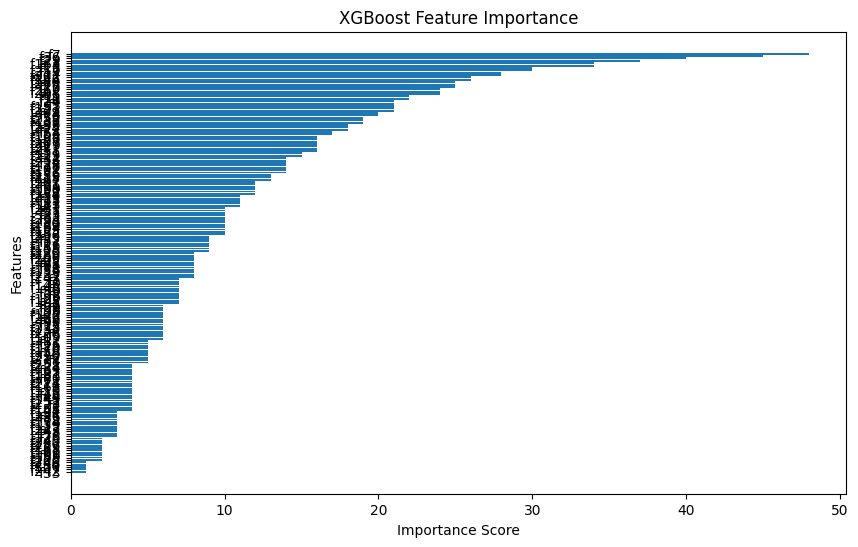

In [116]:
importance = xgb.get_booster().get_score(importance_type='weight')  
# Options: 'weight', 'gain', 'cover', 'total_gain', 'total_cover'

# 2. Convert to DataFrame for easier handling
importance_df = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
})

# 3. Sort by importance
importance_df = importance_df.sort_values(by='importance', ascending=False)

# 4. Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()  # most important at the top
plt.show()

In [117]:
# Metrics
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Balanced Accuracy: 0.5395256916996047

Confusion Matrix:
 [[ 8  8  0]
 [ 5 40 10]
 [ 2 12  9]]

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.50      0.52        16
           1       0.67      0.73      0.70        55
           2       0.47      0.39      0.43        23

    accuracy                           0.61        94
   macro avg       0.56      0.54      0.55        94
weighted avg       0.60      0.61      0.60        94



In [118]:
top20 = importance_df.head(20)

PCA feature selection

In [149]:
pca = PCA(n_components = 20)

In [150]:
scaler_2 = StandardScaler()
X_train_std = scaler_2.fit_transform(X_train)

In [151]:
X_test_std = scaler_2.transform(X_test)

In [152]:
X_train_reduced = pca.fit_transform(X_train_std)

In [153]:
X_train_reduced.shape

(375, 20)

In [154]:
X_test_reduced = pca.transform(X_test_std)

In [155]:
xgb.fit(X_train_reduced, y_train, sample_weight=sample_weights)

y_pred_pca = xgb.predict(X_test_reduced)

In [156]:
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_pca))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_pca))
print("\nClassification Report:\n", classification_report(y_test, y_pred_pca))

Balanced Accuracy: 0.5395256916996047

Confusion Matrix:
 [[ 8  7  1]
 [ 3 40 12]
 [ 1 13  9]]

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.50      0.57        16
           1       0.67      0.73      0.70        55
           2       0.41      0.39      0.40        23

    accuracy                           0.61        94
   macro avg       0.58      0.54      0.56        94
weighted avg       0.60      0.61      0.60        94

